In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import lightgbm
import numpy as np
import catboost

from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool

c:\Users\natha\ProjetsInfo\Kaggle_MAP\Kaggle-MAP\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def grouped_acc(preds, gt, groups=[[1, 2], [3, 4, 5, 6, 7]]):
    preds = np.array(preds)
    gt = np.array(gt)
    count = 0.
    for group in groups :
        count += np.logical_and(np.isin(preds, group),np.isin(gt, group)).sum()
    return count / len(preds)

def intra_group_acc(preds, gt, group=[1, 2]):
    preds = np.array(preds)
    gt = np.array(gt)
    mask = np.isin(gt, group)
    target_preds = preds[mask]
    target_gt = gt[mask]
    return accuracy_score(target_preds, target_gt)

In [5]:
kfold = 5

IMPORT DES DONNEES

In [6]:
# Load the dataset from the provided file "train.csv"
file_path = 'train.csv'  # Update the file path as required
df = pd.read_csv(file_path)
df.head()

eval_df = pd.read_csv('test-full.csv')

In [7]:
cat_feature_1 = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4']
cat_feature_2 = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']



cat_columns = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

num_columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points'
]

for t in cat_feature_1:
    print(t, df[t].to_numpy().sum(), eval_df[t].to_numpy().sum())

print('\n')

for t in cat_feature_2:
    print(t, df[t].to_numpy().sum() ,  eval_df[t].to_numpy().sum() )

Wilderness_Area1 3568 260796
Wilderness_Area2 569 29884
Wilderness_Area3 6302 253364
Wilderness_Area4 4681 36968


Soil_Type1 339 3031
Soil_Type2 627 7525
Soil_Type3 1006 4823
Soil_Type4 839 12396
Soil_Type5 181 1597
Soil_Type6 679 6575
Soil_Type7 1 105
Soil_Type8 2 179
Soil_Type9 4 1147
Soil_Type10 2096 32634
Soil_Type11 376 12410
Soil_Type12 260 29971
Soil_Type13 513 17431
Soil_Type14 173 599
Soil_Type15 0 3
Soil_Type16 106 2845
Soil_Type17 640 3422
Soil_Type18 44 1899
Soil_Type19 53 4021
Soil_Type20 132 9259
Soil_Type21 10 838
Soil_Type22 332 33373
Soil_Type23 742 57752
Soil_Type24 265 21278
Soil_Type25 6 474
Soil_Type26 48 2589
Soil_Type27 8 1086
Soil_Type28 7 946
Soil_Type29 1308 115247
Soil_Type30 736 30170
Soil_Type31 304 25666
Soil_Type32 663 52519
Soil_Type33 619 45154
Soil_Type34 18 1611
Soil_Type35 103 1891
Soil_Type36 14 119
Soil_Type37 32 298
Soil_Type38 744 15573
Soil_Type39 634 13806
Soil_Type40 456 8750


In [ ]:
y = df['Cover_Type']
grouped_y = (df['Cover_Type'] >= 2)

group1_df = df[df['Cover_Type'].isin([1, 2])]
group2_df = df[df['Cover_Type'].isin([3, 4, 5, 6, 7])]

columns_to_drop = ['Id', 'Cover_Type', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type15', 'Soil_Type21', 'Soil_Type25', 'Soil_Type27', 'Soil_Type28', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37']
df = df.drop(columns=columns_to_drop)
group1_df = group1_df.drop(columns=columns_to_drop)
group2_df = group2_df.drop(columns=columns_to_drop)

In [14]:
train_df, test_df, train_y, test_y = train_test_split(df, y, test_size=0.25, random_state=345)
#train_df, test_df, train_y, test_y = train_test_split(df, grouped_y, test_size=0.0001, random_state=345)

cv_X_train = []
cv_X_val = []
cv_y_train = []
cv_y_val = []


seeds = [345 + i for i in range(kfold)]

for i in range(kfold):
    cur_train, cur_val, y_train, y_val =  train_test_split(train_df, train_y, test_size=0.3, random_state=seeds[i])
    cv_X_train.append(cur_train)
    cv_X_val.append(cur_val)
    cv_y_train.append(y_train)
    cv_y_val.append(y_val)

In [15]:
print(cv_X_train[0].shape)
print(grouped_y[:10])

(7938, 43)
0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: Cover_Type, dtype: bool


In [16]:
def perf_LGBM(cv_X_train, cv_y_train, cv_X_val, cv_y_val, hparams, to_normalize=[], verbose=False):

    train_acc_mean = 0
    val_acc_mean = 0
    group_acc_mean = 0
    intra_acc_mean = 0

    for i in range(len(cv_X_train)):

        if(to_normalize != []):
            stdScaler = StandardScaler()
            cv_X_train[i][to_normalize] = stdScaler.fit_transform(cv_X_train[i][to_normalize])
            cv_X_val[i][to_normalize] = stdScaler.fit_transform(cv_X_val[i][to_normalize])
        

        # ENTRAINEMENT 
        lgbm_model = LGBMClassifier(**hparams)
        lgbm_model.fit(cv_X_train[i], cv_y_train[i])

        # RESULTATS TRAIN
        y_train_pred = lgbm_model.predict(cv_X_train[i])

        accuracy = accuracy_score(cv_y_train[i], y_train_pred)
        train_acc_mean += accuracy
        if(verbose) : print(f"train Accuracy: {accuracy:.4f}")

        '''
        cm_train = confusion_matrix(cv_y_train[i], y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=lgbm_model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Train Confusion Matrix")
        plt.show()
        '''
        

        # RESULTATS VAL
        y_val_pred = lgbm_model.predict(cv_X_val[i])
        accuracy = accuracy_score(cv_y_val[i], y_val_pred)
        val_acc_mean += accuracy
        if(verbose) : print(f"test Accuracy: {accuracy:.4f}")

        group_acc_mean += grouped_acc(cv_y_val[i], y_val_pred)
        intra_acc_mean += intra_group_acc(cv_y_val[i], y_val_pred)

        '''
        cm_train = confusion_matrix(cv_y_val[i], y_val_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=lgbm_model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Train Confusion Matrix")
        plt.show()
        '''

    train_acc_mean /= len(cv_X_train)
    val_acc_mean /= len(cv_X_train)
    group_acc_mean /= len(cv_X_train)
    intra_acc_mean /= len(cv_X_train)

    print(f"train Accuracy: {train_acc_mean:.5f}")
    print(f"val Accuracy: {val_acc_mean:.5f}")
    #print(f"grouped val Accuracy: {group_acc_mean:.5f}")
    #print(f"intra val Accuracy: {intra_acc_mean:.5f} \n")

In [17]:
hparams = {'n_estimators':300, 'learning_rate' : 0.04, 'max_depth':3, 'random_state':345, 'verbosity':-1}
l =  {
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 10,
        'num_leaves': 50,
        'min_data_in_leaf': 30,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'lambda_l1': 0.05,
        'lambda_l2': 0.05,
        'random_state': 42,
        'verbosity': -1
    }

In [18]:
perf_LGBM(cv_X_train, cv_y_train, cv_X_val, cv_y_val, hparams)
perf_LGBM([train_df], [train_y], [test_df], [test_y], hparams)

train Accuracy: 0.83789
val Accuracy: 0.78313
train Accuracy: 0.82998
val Accuracy: 0.77249


In [19]:
def optuna_optimization(cv_X_train, cv_y_train, cv_X_val, cv_y_val, num_trials):
    def objective(trial):
        # Define the hyperparameters to tune

        param = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 700),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 100),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
            'random_state' : 345
        }

        '''
        class_weights = {
            1: trial.suggest_float('class_weight_1', 1.0, 2.0),
            2: trial.suggest_float('class_weight_2', 1.0, 2.0),
            7: 1.0, 
            3: 1.0,
            4: 1.0,
            5: 1.0,
            6: 1.0
        }
        '''

        ret = 0

        for i in range(len(cv_X_train)):

            # Train the model
            model = LGBMClassifier(**param)
            model.fit(cv_X_train[i], cv_y_train[i])
            
            # Predict and calculate accuracy
            val_preds = model.predict(cv_X_val[i])
            val_accuracy = accuracy_score(cv_y_val[i], val_preds)

            # Predict and calculate accuracy
            train_preds = model.predict(cv_X_train[i])
            train_accuracy = accuracy_score(cv_y_train[i], train_preds)

            g_acc = grouped_acc(cv_y_val[i], val_preds)
            int_acc = 0.7*intra_group_acc(cv_y_val[i], val_preds)

            ret -= (g_acc / kfold)
        
        # Minimize the negative of accuracy to maximize it
        return ret
    # Step 3: Run the Optimization
    study = optuna.create_study(direction='minimize')  # Use 'maximize' if metric doesn't need negation
    study.optimize(objective, n_trials=num_trials)  # Adjust n_trials as needed

    # Step 4: Best Parameters and Score
    print("Best Trial:")
    print(study.best_trial.params)
    print("Best Score:", -study.best_value)

    perf_LGBM([train_df], [train_y], [test_df], [test_y], study.best_trial.params)

In [20]:
optuna_optimization(cv_X_train, cv_y_train, cv_X_val, cv_y_val, 100)

[I 2024-11-21 13:14:01,273] A new study created in memory with name: no-name-822c61d9-e13b-43d1-bd3a-070971900d48
[I 2024-11-21 13:14:06,369] Trial 0 finished with value: -0.8966490299823633 and parameters: {'n_estimators': 349, 'learning_rate': 0.0023854002231073063, 'max_depth': 5, 'min_data_in_leaf': 80, 'lambda_l1': 3.4635158304708846, 'lambda_l2': 2.840836383879421}. Best is trial 0 with value: -0.8966490299823633.
[I 2024-11-21 13:14:16,821] Trial 1 finished with value: -0.9439741328630218 and parameters: {'n_estimators': 395, 'learning_rate': 0.06602103193329402, 'max_depth': 10, 'min_data_in_leaf': 85, 'lambda_l1': 4.317621409729175, 'lambda_l2': 0.5035386956583493}. Best is trial 1 with value: -0.9439741328630218.
[I 2024-11-21 13:14:23,929] Trial 2 finished with value: -0.9044679600235156 and parameters: {'n_estimators': 508, 'learning_rate': 0.003279151868486862, 'max_depth': 5, 'min_data_in_leaf': 78, 'lambda_l1': 1.2225329573140957, 'lambda_l2': 4.275294670643342}. Best is

Best Trial:
{'n_estimators': 558, 'learning_rate': 0.08487057809181667, 'max_depth': 10, 'min_data_in_leaf': 98, 'lambda_l1': 0.021748306485209284, 'lambda_l2': 3.395730533019961}
Best Score: 0.9544385655496768
train Accuracy: 1.00000
val Accuracy: 0.86138


In [47]:
# code pour le grouped LGBM 
sparams = {'n_estimators': 542, 'learning_rate': 0.0876831946773108, 'max_depth': 10, 'min_data_in_leaf': 33, 'lambda_l1': 0.12769010786966128, 'lambda_l2': 4.294573810725201}

perf_LGBM(cv_X_train, cv_y_train, cv_X_val, cv_y_val, sparams)

train Accuracy: 0.99802
val Accuracy: 0.93042


In [13]:
selected_params ={'n_estimators': 374, 'learning_rate': 0.04467153355073192, 'max_depth': 7, 'min_data_in_leaf': 25, 'lambda_l1': 2.99364222555518, 'lambda_l2': 4.993380246872226}

perf_LGBM([train_df], [train_y], [test_df], [test_y],selected_params)
perf_LGBM(cv_X_train, cv_y_train, cv_X_val, cv_y_val, selected_params)

train Accuracy: 0.95979
val Accuracy: 0.84392
train Accuracy: 0.96891
val Accuracy: 0.82671


In [ ]:
'''
{'n_estimators': 243, 'learning_rate': 0.09497224225578486, 'max_depth': 7, 'min_data_in_leaf': 36, 'lambda_l1': 0.0473458245965267, 'lambda_l2': 1.1625771874476278}
train Accuracy: 0.99859
val Accuracy: 0.85159
train Accuracy: 0.99986
val Accuracy: 0.83643

{'n_estimators': 537, 'learning_rate': 0.06306343031424105, 'max_depth': 8, 'min_data_in_leaf': 50, 'lambda_l1': 0.3610306680518738, 'lambda_l2': 0.6695181840712005} 
train Accuracy: 1.00000
val Accuracy: 0.86971
train Accuracy: 1.00000
val Accuracy: 0.83678

{'n_estimators': 569, 'learning_rate': 0.044996370852898315, 'max_depth': 8, 'min_data_in_leaf': 35, 'lambda_l1': 2.1878957763043703, 'lambda_l2': 1.8231742727891733}
train Accuracy: 0.99347
val Accuracy: 0.84974
train Accuracy: 0.99531
val Accuracy: 0.83406

{'n_estimators': 422, 'learning_rate': 0.09540261159939917, 'max_depth': 8, 'min_data_in_leaf': 63, 'lambda_l1': 0.18252058337924315, 'lambda_l2': 0.07505410805504859}
train Accuracy: 1.00000
val Accuracy: 0.86429
train Accuracy: 1.00000
val Accuracy: 0.84228

{'n_estimators': 587, 'learning_rate': 0.04222136637708149, 'max_depth': 7, 'min_data_in_leaf': 32, 'lambda_l1': 1.0182542748945071, 'lambda_l2': 0.2683280303950699}
train Accuracy: 0.99947
val Accuracy: 0.85185
train Accuracy: 0.99995
val Accuracy: 0.83860

{'n_estimators': 374, 'learning_rate': 0.04467153355073192, 'max_depth': 7, 'min_data_in_leaf': 25, 'lambda_l1': 2.99364222555518, 'lambda_l2': 4.993380246872226}
train Accuracy: 0.95979
val Accuracy: 0.84392
train Accuracy: 0.96891
val Accuracy: 0.82671

'''

# CATBOOST

In [65]:
catboost_train_df = train_df_raw_w_cat
catboost_test_df = test_df_raw_w_cat

In [66]:
# création d'un nouveau df
# Create new feature 'Soil_Type' by finding the index of the max value in each row
catboost_train_df['Soil_Type'] = (np.argmax(catboost_train_df[cat_feature_2].values, axis=1)).astype(str)
catboost_train_df['Wilderness_Area'] = (np.argmax(catboost_train_df[cat_feature_1].values, axis=1)).astype(str)

# Drop the one-hot encoded columns if no longer needed
catboost_train_df = catboost_train_df.drop(columns=cat_feature_2)
catboost_train_df = catboost_train_df.drop(columns=cat_feature_1)

catboost_test_df['Soil_Type'] = (np.argmax(catboost_test_df[cat_feature_2].values, axis=1)).astype(str)
catboost_test_df['Wilderness_Area'] = (np.argmax(catboost_test_df[cat_feature_1].values, axis=1)).astype(str)

# Drop the one-hot encoded columns if no longer needed
catboost_test_df = catboost_test_df.drop(columns=cat_feature_2)
catboost_test_df = catboost_test_df.drop(columns=cat_feature_1)


X_train = catboost_train_df
y_train = train_y

X_test = catboost_test_df
y_test = test_y

In [67]:
print(catboost_train_df.shape)
print(catboost_train_df.columns)
print(catboost_train_df.head())

(12351, 12)
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type', 'Wilderness_Area'],
      dtype='object')
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2881     130     22                               210   
1       3005     351     14                               242   
2       3226      63     14                               618   
3       3298     317      8                               661   
4       3080      35      6                               175   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              54                             1020   
1                             -16                             1371   
2                               2                             1092   
3      

In [68]:
# Specify categorical features by their column indices
categorical_features = ['Soil_Type', 'Wilderness_Area']

model = CatBoostClassifier(
    iterations=500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=6,  # Depth of trees
    cat_features=categorical_features,  # Specify categorical features
    verbose=100  # Print updates every 100 iterations
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Make predictions
y_train_pred = model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
print(f"train Accuracy: {accuracy:.4f}")
# Make predictions
y_test_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"test Accuracy: {accuracy:.4f}")

0:	learn: 1.7410109	test: 1.7438212	best: 1.7438212 (0)	total: 41.8ms	remaining: 20.8s
100:	learn: 0.5436547	test: 0.5858013	best: 0.5858013 (100)	total: 4.05s	remaining: 16s
200:	learn: 0.4397284	test: 0.5046524	best: 0.5046524 (200)	total: 8s	remaining: 11.9s
300:	learn: 0.3814965	test: 0.4628985	best: 0.4628985 (300)	total: 12s	remaining: 7.95s
400:	learn: 0.3417074	test: 0.4400193	best: 0.4400193 (400)	total: 16.2s	remaining: 3.99s
499:	learn: 0.3053961	test: 0.4193972	best: 0.4193972 (499)	total: 20.4s	remaining: 0us

bestTest = 0.4193971575
bestIteration = 499

train Accuracy: 0.9010
test Accuracy: 0.8386



Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.75      0.75       390
           2       0.77      0.64      0.70       391
           3       0.85      0.76      0.80       410
           4       0.91      0.97      0.94       384
           5       0.84      0.93      0.89       406
           6       0.82      0.88      0.85       405
           7       0.92      0.95      0.93       383

    accuracy                           0.84      2769
   macro avg       0.84      0.84      0.84      2769
weighted avg       0.84      0.84      0.84      2769



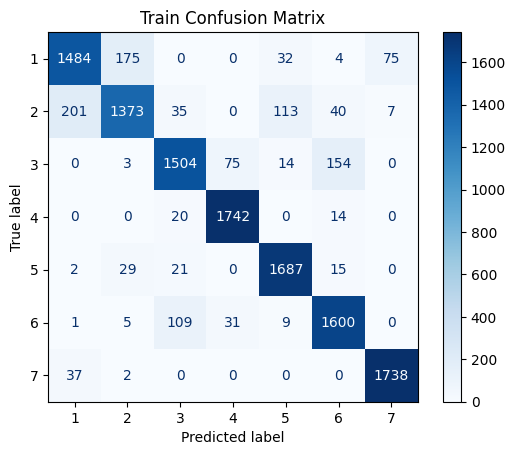

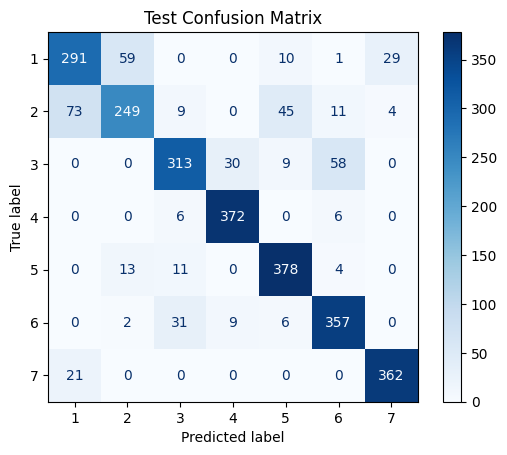

In [69]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# SUBMISSION

In [14]:
final_model = LGBMClassifier(**{'n_estimators': 537, 'learning_rate': 0.06306343031424105, 'max_depth': 8, 'min_data_in_leaf': 50, 'lambda_l1': 0.3610306680518738, 'lambda_l2': 0.6695181840712005} )
final_model.fit(train_df, train_y)

LGBMClassifier(lambda_l1=0.3610306680518738, lambda_l2=0.6695181840712005,
               learning_rate=0.06306343031424105, max_depth=8,
               min_data_in_leaf=50, n_estimators=537)

test Accuracy: 0.8598


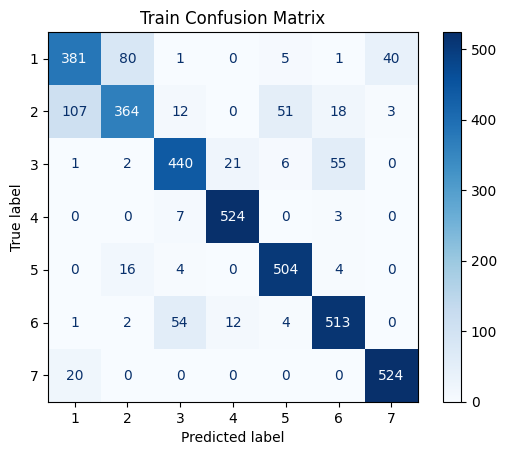

In [39]:
y_val_pred = final_model.predict(test_df)
accuracy = accuracy_score(test_y, y_val_pred)
print(f"test Accuracy: {accuracy:.4f}")

cm_train = confusion_matrix(test_y, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

In [16]:
eval_df = pd.read_csv('test-full.csv')
eval_df = eval_df.drop(columns=['Id',  'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type15', 'Soil_Type21', 'Soil_Type25', 'Soil_Type27', 'Soil_Type28', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37'])

In [54]:
print(eval_df.shape)
print(df.shape)
print(eval_df.columns)
print(df.columns)

(581012, 43)
(15120, 43)
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type26', 'Soil_Type29',
       'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33',
       'Soil_Type35', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Dist

In [17]:
ans = final_model.predict(eval_df)

In [18]:
ans_df = pd.DataFrame(ans, columns=['Cover_Type'])
ans_df['Id'] = ans_df.index + 1
ans_df = ans_df[['Id', 'Cover_Type']]

In [57]:
ans_df.to_csv('submission16_11_3.csv', index=False)

In [26]:
print(np.unique(ans_df['Cover_Type']))
for i in range(1, 8):
    print(ans_df[ans_df['Cover_Type'] == i].shape[0] / ans_df.shape[0])

[1 2 3 4 5 6 7]
0.37285632654747236
0.38402304943787735
0.06378009404280807
0.0075420129016268165
0.0647731888498
0.0471986809222529
0.05982664729816252


In [38]:
unique_values, counts = np.unique(y, return_counts=True)

# Display results
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears at freq {count / len(y)}.")

Value 1 appears at freq 0.14285714285714285.
Value 2 appears at freq 0.14285714285714285.
Value 3 appears at freq 0.14285714285714285.
Value 4 appears at freq 0.14285714285714285.
Value 5 appears at freq 0.14285714285714285.
Value 6 appears at freq 0.14285714285714285.
Value 7 appears at freq 0.14285714285714285.


In [36]:
print(len(y))

15120


In [41]:
df_init = pd.read_csv('train.csv')

In [45]:
print(df_init[['Id', 'Cover_Type']])

           Id  Cover_Type
0      242642           1
1      309891           1
2      287847           1
3      516307           1
4      124860           1
...       ...         ...
15115  475155           7
15116  514378           7
15117  368425           7
15118  537844           7
15119  463634           7

[15120 rows x 2 columns]


In [ ]:
df_sorted = df_init.sort_values(by=['Id'])
hhp = df_sorted[['Id', 'Cover_Type']]


           Id  Cover_Type
10190       5           5
9599       11           5
10083      14           5
8888       16           5
10498      19           5
...       ...         ...
6406   580950           3
5073   580952           3
6412   580976           3
4996   580989           3
5649   581005           3

[15120 rows x 2 columns]


In [66]:
x = np.random.randint(0, 15000)
print(x, '\n')
print(hhp[x:x+40])

6547 

           Id  Cover_Type
5336   258444           3
7646   258447           4
7129   258448           4
6631   258449           4
4482   258452           3
5986   258467           3
4924   258483           3
5961   258526           3
14284  258542           7
14150  258547           7
3774   258634           2
2735   258843           2
4091   258869           2
10437  258892           5
1024   258893           1
8390   258929           4
5213   258931           3
5893   258939           3
4909   258942           3
6167   258991           3
6756   259000           4
5566   259001           3
4606   259016           3
5740   259062           3
6202   259067           3
4953   259083           3
4739   259087           3
5847   259096           3
14950  259103           7
14267  259107           7
14689  259113           7
2605   259264           2
8669   259398           5
4158   259406           2
6041   259496           3
5523   259501           3
4522   259516           3
6866 

In [ ]:
print(eval_df.shape)
print()

(581012, 43)


In [67]:
subf1 = pd.read_csv('submission16_11_3.csv')

In [69]:
subf1['Cover_Type'] = 1

In [70]:
print(subf1)

            Id  Cover_Type
0            1           1
1            2           1
2            3           1
3            4           1
4            5           1
...        ...         ...
581007  581008           1
581008  581009           1
581009  581010           1
581010  581011           1
581011  581012           1

[581012 rows x 2 columns]


In [ ]:
'''
acc générale 
acc groupé = 1 si prévu (1, 2) et dans (1, 2) ou 
acc intra 1/2 
'''



In [12]:
p1 = np.array([1, 2, 1, 3, 4, 6, 1])
p2 = np.array([1, 2, 1, 3, 5, 6, 2])
print(grouped_acc(p1, p2))
print(intra_group_acc(p1, p2))

1.0
0.75
